# Homework 5 - Exploring StackOverflow!

## 1. Data

In [3]:
import sys
sys.path.append('/home/petar/Documents/PythonUniProjects/adm-hw5/venv/lib/python3.8/site-packages')

In [4]:
# First, import required libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from queue import PriorityQueue
from networkx.algorithms.dag import dag_longest_path
from tabulate import tabulate
import seaborn as sns

The first step, as always, is to download the data we will be working on. We downloaded the 3 files which contains : 

['Answers to questions', 'Comments to questions', 'Comments to answers']

In [5]:
df1 = pd.read_csv('sx-stackoverflow-a2q.txt', nrows=10000, header=None)
df2 = pd.read_csv('sx-stackoverflow-c2q.txt', nrows=10000, header=None)
df3 = pd.read_csv('sx-stackoverflow-c2a.txt', nrows=10000, header=None)

In [6]:
def expand_column(df):
    """

    :param df: dataframe
    :return: df with different columns for each value for the rows
    """
    df = pd.concat([df[[0]], df[0].str.split(' ', expand=True)], axis=1)
    df.columns = ['N', 'u1', 'u2', 't']
    df = df.drop('N', axis=1)
    df.loc[:, 'u1'] = df.loc[:, 'u1']
    df.loc[:, 'u2'] = df.loc[:, 'u2']
    return df

In [7]:
def draw_graph(G):
    """

    :param G: Graph
    :return: draws the graph
    """
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, pos)
    # nx.draw_networkx_edge_labels(G, pos)
    plt.show()
    # pass


In [9]:
def get_edge_labels(G):
    edge_labels = {}
    for u, v, e in G.edges(data=True):
        edge_labels[(u, v)] = e['type']
    return edge_labels

In [8]:
df1 = expand_column(df1)
df1['type'] = 'a'  # User answers user q
df2 = expand_column(df2)
df2['type'] = 'c_q'  # User comments user q
df3 = expand_column(df3)
df3['type'] = 'c_a'  # User comments user a
frames = [df1, df2, df3]

In [10]:
df = pd.concat(frames)  # Merge them

G1 = nx.DiGraph()  # Create directed graph
# connections = {}
structure = []  # Needed to create the graph with the edges (networkx accepts it that way)

for u1, u2, *_ in df.values:
    structure.append((u1, u2))

G1.add_edges_from(structure)

In [11]:
for u1, u2, t, type, *_ in df.values:  # To add the timestamps and types, we do the following: for each pair, if already encountered, add the new timestamp and type to the existing array, otherwise: initialize the array with the current timestamp/type of connection
    edge_attributes = G1[u1][u2]
    if 'type' not in edge_attributes.keys():
        G1[u1][u2]['type'] = [type]  # Initialize only 1 type in the array
    else:
        G1[u1][u2]['type'].append(type)  # If it has been visited, add the type to the existing array
    if 't' not in edge_attributes.keys():
        G1[u1][u2]['t'] = [t]  # Same logic for the timestamp
    else:
        G1[u1][u2]['t'].append(t)  # Same logic
    if 'weight' not in edge_attributes.keys():
        G1[u1][u2]['weight'] = 1  # Also increase the weights
    else:
        G1[u1][u2]['weight'] += 1

In [12]:
G = nx.from_pandas_edgelist(df, 'u1', 'u2', ['t', 'type'], create_using=nx.DiGraph())
edge_labels = get_edge_labels(G)
#draw_graph(G1)

## 2. Implementation of the backend

### Functionality 1 - Get the overall features of the graph

**The output should return:**

- Whether the graph is directed or not
- Number of users
- Number of answers/comments
- Average number of links per user
- Density degree of the graph
- Whether the graph is sparse or dense

In [13]:
def is_undirected(G):
    nodes = G.edges()
    for pair in nodes:
        u1 = pair[0]
        u2 = pair[1]
        reverse_pair = (u2, u1)
        if reverse_pair not in nodes:  # This means that the reverse edge (u2, u1) is not in the edge list, 
            return False # we only have one direction. This means that this graph is not undirected.  
    return True
is_undirected(G)

False

In [14]:
def num_of_users(G):
    users_1 = [u[0] for u in G.edges(data=True)]
    users_2 = [u[1] for u in G.edges(data=True)]
    num_of_user = len(set(users_1 + users_2)) # We used "set" to get unique values
    return num_of_user
num_of_users(G)

6858

In [15]:
def num_of_answers(G):
    answers = [a[2]['type'] for a in G.edges(data=True) if str(a[2]['type']).startswith('a')]
    num_of_answer = len(answers)
    return num_of_answer
num_of_answers(G)

8782

In [16]:
def num_of_comments(G):
    list1 = [list(c[2].values()) for c in G.edges(data=True)]
    comments = [c[1] for c in list1 if str(c[1]).startswith('c')]
    num_of_comment = len(comments)
    return  num_of_comment
num_of_comments(G)

16256

In [17]:
def Avg_links_per_user(G):
    user_links={}
    users_1 = [u[0] for u in G.edges(data=True)]
    users_2 = [u[1] for u in G.edges(data=True)]
    users= users_1 + users_2
    for u in users:
        if u in user_links.keys():
            user_links[u]+=1
        else:
            user_links[u]=1
    return np.mean(list(user_links.values()))
                   
Avg_links_per_user(G) 

7.301837270341207

   In the paper of "The authors followed E. Lawler (1976), Combinatorial Optimization: Networks and Matroids", we can see that the definition of density is,

   While for directed simple graphs, where |E| is the number of edges and |V| is the number of vertices in the graph the graph density is defined as :

**Maximum Number of Edges = num_nodes * (num_nodes - 1)**

**D = E / V * (V-1)**

In [18]:
den= nx.density(G)
den

0.0005324367267275198

In [19]:
def density(G):
    node_users_1 = [u[0] for u in G.edges(data=True)]
    node_users_2 = [u[1] for u in G.edges(data=True)]
    num_nodes = len(set(node_users_1 + node_users_2))
    num_edges = len([a for a in G.edges(data=True)]) # The number of edges is equal to total rows in dataframe
    D = (num_edges) / ((num_nodes-1)*num_nodes)
    return D
density(G)

0.0005324367267275198

In [20]:
def check_dense(G):
    if density(G)<=0.5:
        return("Sparse Graph")
    else:
        return("Dense Graph")
check_dense(G)

'Sparse Graph'

### Functionality 2 - Find the best users!
It takes in input:

A user/node \
An interval of time \
One of the following metrics: Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality \
The output should return:

The value of the given metric applied over the complete graph for the given interval of time \
Give an explanaition regarding the features of the user based on all of the metrics (e.g. if the betweeness metric is high, what does this mean in practice, what if the betweeness is low but it has a high PageRank value, etc.)

In [21]:
def remove_edges(G, interval):
    """
    Remove all the edges that are not in the specified interval
    :param G:
    :param interval:
    :return:
    """
    H = G.copy()
    t0 = interval[0]
    t1 = interval[1]
    selected_nodes = [(u, v, e) for u, v, e in H.edges(data=True) if (int(e['t']) < t0 or t1 < int(e['t']))]

    for triplet in selected_nodes:
        e = triplet[2]
        u = triplet[0]
        v = triplet[1]

        if int(e['t']) < t0 or t1 < int(e['t']):
            H.remove_edge(u, v)
    return H

In [22]:
# Functionality 2
def degree_centrality(G, interval):
    """

    :param G: graph
    :return: the degree centrality of G (The number of edges in the graph)
    """

    H = filter_time(G, interval)

    return H.number_of_edges()


# print(G.number_of_edges())

### Functionality 3 - Shortest Ordered Route

In [24]:
# Functionality 3

def dijkstra(G, n1, n2=None):
    """
    Dijkstra algorithm
    :param G: graph
    :param n1: Starting node
    :param n2:
    :return: list with shortest distances to all other nodes from node n1
    """
    pq = PriorityQueue()
    elements = [(u, v, e) for u, v, e in G.edges(data=True)]
    weights = {}

    for element in elements:
        weights[(element[0], element[1])] = element[2]['weight']

    shortest_paths = {}
    for n in G.nodes:
        shortest_paths[n] = float('inf')
    # print('Weights: ', weights)
    # print('Shortest paths: ', shortest_paths)

    visited = []

    shortest_paths[n1] = 0

    pq.put((0, n1))

    while not pq.empty():
        (weight, n) = pq.get()
        visited.append(n)
        neighbours = G.out_edges(n)

        for neighbour_pair in neighbours:
            neighbour = neighbour_pair[1]
            if neighbour not in visited:
                weight = weights[(n, neighbour)]
                old_cost = shortest_paths[neighbour]  # Old shortest path to that node
                new_cost = shortest_paths[n] + weight
                if new_cost < old_cost:
                    pq.put((new_cost, neighbour))
                    shortest_paths[neighbour] = new_cost
    return shortest_paths[n2]


In [25]:
def is_in(t, t1, t2):
    """
    :param t1: start time
    :param t2: end time
    :param t: timestamp array
    :return: whether all timestamps in t are in range [t1, t2]
    """
    return sum([1 if int(t1) <= int(tj) <= int(t2) else 0 for tj in t]) == len(t)

In [26]:
def filter_time(G, interval):
    H = G.copy()
    t1 = interval[0]
    t2 = interval[1]
    edges = H.edges(data=True)

    edges_to_remove = []

    for edge in edges:
        if not is_in(edge[2]['t'], t1, t2):
            edges_to_remove.append((edge[0], edge[1]))
    for edge_to_remove in edges_to_remove:
        H.remove_edge(edge_to_remove[0], edge_to_remove[1])
    return H

In [27]:
def shortest_walk(G, interval, users, u1, u2):
    """

    :param G: graph
    :param interval:  which to consider
    :param users: which to consider
    :param u1: initial user
    :param u2: end user
    :return: shortest path
    """

    # 1. Check the interval of time.
    H = filter_time(G, interval)
    # 2. Consider the sequence of users.
    all_users = [u1, *users, u2]
    distance = 0
    for i in range(len(all_users)):
        end = i == len(all_users) - 1
        if not end:
            u1 = all_users[i]
            u2 = all_users[i + 1]
            shortest_distance = dijkstra(H, n1=u1, n2=u2)
            distance += shortest_distance
    if distance == float('inf'):
        return 'Not possible'
    return distance


In [28]:
# Initial_filtering
print(f'G1 num edges: {G1.number_of_edges()}')
initial_filter = ['1221373607', '1223004802']
G1_time_filtered = filter_time(G1, initial_filter)
print(f'G1_time_filtered num edges: {G1_time_filtered.number_of_edges()}')

print('Running dijkstra...')
print(dijkstra(G1, n1='9', n2='8'))
#
t = ['1201373607', '1317618183']  # Time interval
print('Total cost is: ', shortest_walk(G1, interval=t, u1='22', users=['26', '58', '192', '258', '12791'], u2='15353'))
print('Degree centrality: ', degree_centrality(G1, t))

G1 num edges: 25038
G1_time_filtered num edges: 9514
Running dijkstra...
1
Total cost is:  8
Degree centrality:  25038


## 3. Implementation of the frontend

### Visualization 1 - Visualize the overall features of the graph

Output a table with all of the information requested. The visualization also generates a plot of the density distribution of the graph provided as input.

In [29]:
initial_filter_1 = ['1221373607', '1223004802']
G2 = filter_time(G1, initial_filter_1)
initial_filter_2 = ["1221014091",'1221167127']
G3 = filter_time(G1, initial_filter_2)
G3.number_of_edges()

422

In [30]:
num_of_answers(G)

8782

In [31]:
data = [["Graph_1",num_of_users(G1), num_of_answers(G1),num_of_comments(G1),Avg_links_per_user(G1),density(G1),check_dense(G1)], 
        ["Graph_2",num_of_users(G2), num_of_answers(G2),num_of_comments(G2),Avg_links_per_user(G2),density(G2),check_dense(G2)],
        ["Graph_3",num_of_users(G3), num_of_answers(G3),num_of_comments(G3),Avg_links_per_user(G3),density(G3),check_dense(G3)]]

headers=["Num of users","Num of answers","Num of comments","Avg links per user","Density","Checking dense"]
print(tabulate(data,headers = headers, tablefmt='fancy_grid'))

╒═════════╤════════════════╤══════════════════╤═══════════════════╤══════════════════════╤═════════════╤══════════════════╕
│         │   Num of users │   Num of answers │   Num of comments │   Avg links per user │     Density │ Checking dense   │
╞═════════╪════════════════╪══════════════════╪═══════════════════╪══════════════════════╪═════════════╪══════════════════╡
│ Graph_1 │           6858 │                0 │                 0 │              7.30184 │ 0.000532437 │ Sparse Graph     │
├─────────┼────────────────┼──────────────────┼───────────────────┼──────────────────────┼─────────────┼──────────────────┤
│ Graph_2 │           4362 │                0 │                 0 │              4.36222 │ 0.00050014  │ Sparse Graph     │
├─────────┼────────────────┼──────────────────┼───────────────────┼──────────────────────┼─────────────┼──────────────────┤
│ Graph_3 │            398 │                0 │                 0 │              2.1206  │ 0.00267078  │ Sparse Graph     │
╘═══════

In [32]:
edges = list(G.edges())
num_edges_list = [i for i in range(1,len(edges)+1)]
num_nodes =[]
for x in range(1,len(edges)+1):
    node_users_1 = [u[0] for u in edges[:x]]
    node_users_2 = [u[1] for u in edges[:x]]
    num_node = len(set(node_users_1)) + len(set(node_users_2))
    num_nodes.append(num_node)

dense_df = pd.DataFrame()
dense_df["num_edges_list"] = num_edges_list
dense_df["num_nodes"] = num_nodes
dense_df["density"] = dense_df["num_edges_list"] / ((dense_df["num_nodes"]-1)*(dense_df["num_nodes"]))
dense_df

,num_edges_list,num_nodes,density
0,1,2,0.500000
1,2,3,0.333333
2,3,4,0.250000
3,4,5,0.200000
4,5,6,0.166667
...,...,...,...
25033,25034,10437,0.000230
25034,25035,10439,0.000230
25035,25036,10440,0.000230
25036,25037,10441,0.000230


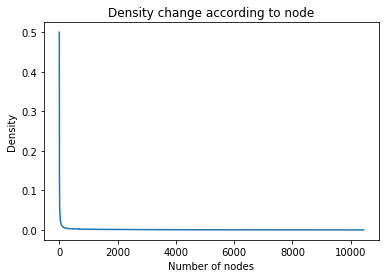

In [33]:
plt.plot(dense_df["num_nodes"],dense_df["density"])
plt.title('Density change according to node')
plt.xlabel('Number of nodes')
plt.ylabel('Density')
plt.show()

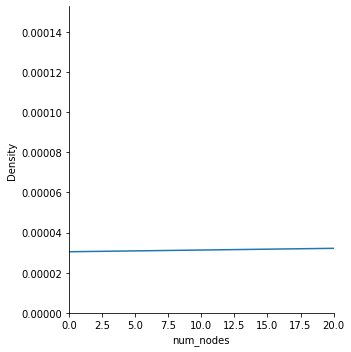

In [34]:
sns.displot(data=dense_df, x="num_nodes", kind="kde").set(xlim=(0,20))

In [ ]:
#Functionality 4

In [35]:
def kids_split():
    room1 = [] # for storing list of kids in first room
    room2 = [] # for storing list of kids in first room
    set1 = [] # for storing the another pair of kids which are figthing
    set2 = [] # for storing the another pair of kids which are figthing

    for i in Pairs: 
        
        if i[0] in room1: # check if the first kid of pairs exist in room 1
            if i[1] in set2: # check if any another kid exists in room 2 which are figthing
                print("No combination, Cant split kids") 
                
            else:
                room2.append(i[1]) # if firs pair is in room1 then add second one to room2
                set2.append(i[0]) # add kid to list for room2
                set1.append(i[1]) # add another kid to list for room1
                

        elif i[0] in room2: #  if firs pair is not in room1 then search in room 2
            if i[1] in set1: #also in pair list
                print("No combination, Cant split kids")
                
            else:
                room1.append(i[1]) # if firs pair is in room2 then add another pair to room1
                set1.append(i[0]) # add kid to list for room1
                set2.append(i[1]) # add another kid to list for room2
                

        elif i[1] in room1: #if first kid is not exist in any room the look up second kid
            if i[0] in set2: # also in pair list
                print("No combination, Cant split kids")
                
            else:
                room2.append(i[0]) #if second kid exist in room 1 then add first kid to room2
                set2.append(i[1]) #add kid name to the list for room2
                set1.append(i[0]) #add another kid name to the list for room1
                

        elif i[1] in room2: #if second kid is not exist in room 1 then search in room2
            if i[0] in set1: # also in pair list
                print("No combination, Cant split kids")
                
            else:
                room1.append(i[0]) #if second kid exist in room 2 then add first kid to room1
                set1.append(i[1]) # add second kid name to the list for room1
                set2.append(i[0]) # add first kid name to the list for room2 
                

        else:  # if both of the kids is not in room1 and room2 
            room1.append(i[0]) # split first kid to room 1
            set1.append(i[1]) #add Second kid name to the list for room 1
            room2.append(i[1]) # split second kid to room 2
            set2.append(i[0]) #add first kid name to the list for room 2
            
            
            
    for j in Students: #add rest of kids to room1 no space limit
        if j not in room1 and j not in room2:
            room1.append(j)
            

    print("Reccomended Assignment to 1st Room: ", room1)
    print("Reccomended Assignment to 2nd Room: ", room2)

In [36]:
Students = ['Aqil', 'Seymur', 'Dilan', 'Fariz', 'Gunes', 'Hasan']
Pairs = [['Aqil', 'Dilan'], ['Dilan', 'Fariz'], ['Aqil', 'Fariz']]
kids_split()

No combination, Cant split kids
Reccomended Assignment to 1st Room:  ['Aqil', 'Fariz', 'Seymur', 'Gunes', 'Hasan']
Reccomended Assignment to 2nd Room:  ['Dilan']


In [37]:
Kids = ['Aqil', 'Seymur', 'Dilan', 'Fariz', 'Gunes', 'Hasan']
Pairs = [['Aqil', 'Dilan'], ['Dilan', 'Fariz'], ['Gunes', 'Hasan']]
kids_split()

Reccomended Assignment to 1st Room:  ['Aqil', 'Fariz', 'Gunes', 'Seymur']
Reccomended Assignment to 2nd Room:  ['Dilan', 'Hasan']


In [38]:
Kids = ['Aqil', 'Seymur', 'Dilan', 'Fariz', 'Gunes', 'Hasan', 'Elgun', 'Atilla']
Pairs = [['Aqil', 'Dilan'], ['Dilan', 'Fariz'], ['Gunes', 'Hasan'],['Hasan','Atilla']]
kids_split()

Reccomended Assignment to 1st Room:  ['Aqil', 'Fariz', 'Gunes', 'Atilla', 'Seymur']
Reccomended Assignment to 2nd Room:  ['Dilan', 'Hasan']


In [39]:
Kids = ['Aqil', 'Seymur', 'Dilan', 'Fariz', 'Gunes', 'Hasan', 'Elgun', 'Atilla','Tural','Fuad']
Pairs = [['Aqil', 'Dilan'], ['Dilan', 'Fariz'], ['Gunes', 'Hasan'],['Hasan','Atilla'],['Tural','Fuad']]
kids_split()

Reccomended Assignment to 1st Room:  ['Aqil', 'Fariz', 'Gunes', 'Atilla', 'Tural', 'Seymur']
Reccomended Assignment to 2nd Room:  ['Dilan', 'Hasan', 'Fuad']
